# Underwater Robotics - Grid World POMDP

In [1]:
# first import the POMDPs.jl interface
using POMDPs
# POMDPModelTools has tools that help build the MDP definition
using POMDPModelTools
# POMDPPolicies provides functions to help define simple policies
using POMDPPolicies
# POMDPSimulators provide functions for running MDP simulations
using POMDPSimulators
using Debugger
using ColorSchemes, Colors
using Plots
using QMDP
using LinearAlgebra

## States
The data container below represents the state of the agent in the grid world.

In [2]:
struct GridWorldState 
    x::Int64 # x position
    y::Int64 # y position
    done::Bool # are we in a terminal state?
end

Below are some convenience functions for working with the GridWorldState. 

In [3]:
# initial state constructor
GridWorldState(x::Int64, y::Int64) = GridWorldState(x,y,false)

# checks if the position of two states are the same
posequal(s1::GridWorldState, s2::GridWorldState) = s1.x == s2.x && s1.y == s2.y

posequal (generic function with 1 method)

## MDP
The GridWorld data container is defined below. It holds all the information we need to define the POMDP tuple $$(\mathcal{S}, \mathcal{A}, \mathcal{O}, T, R, O, \gamma).$$

In [4]:
# the grid world mdp type
mutable struct GridWorld <: POMDP{GridWorldState, Symbol, GridWorldState} # Note that our MDP is parametarized by the state and the action
    size_x::Int64 # x size of the grid
    size_y::Int64 # y size of the grid
    reward_states::Vector{GridWorldState} # the states in which agent recieves reward
    reward_values::Vector{Float64} # reward values for those states
    tprob::Float64 # probability of transitioning to the desired state
    oprob::Float64 # probability of observing that the agent is in the current state
    discount_factor::Float64 # disocunt factor
end

Before moving on, I want to create a constructor for GridWorld for convenience. Currently, if I want to create an instance of GridWorld, I have to pass in all of fields inside the GridWorld container (size_x, size_y, etc). The function below will return a GridWorld type with all the fields filled with some default values.

In [5]:
#we use key worded arguments so we can change any of the values we pass in 
function GridWorld(;sx::Int64=5, # size_x
                    sy::Int64=5, # size_y
                    rs::Vector{GridWorldState}=[GridWorldState(5,5), GridWorldState(3,4), GridWorldState(1,3), GridWorldState(4,2)], # reward states
                    rv = [10., -10., -5., -3.], # reward values
                    tp::Float64=0.7, # tprob
                    op::Float64=0.8, # observation prob
                    discount_factor::Float64=0.9)
    return GridWorld(sx, sy, rs, rv, tp, op, discount_factor)
end

# we can now create a GridWorld mdp instance like this:
mdp = GridWorld()
mdp.reward_states # mdp contains all the defualt values from the constructor



4-element Vector{GridWorldState}:
 GridWorldState(5, 5, false)
 GridWorldState(3, 4, false)
 GridWorldState(1, 3, false)
 GridWorldState(4, 2, false)

In [6]:
# #we use key worded arguments so we can change any of the values we pass in 
# function GridWorld(;sx::Int64=5, # size_x
#                     sy::Int64=5, # size_y
#                     rs::Vector{GridWorldState}=[GridWorldState(5,5), GridWorldState(4,3)], # reward states
#                     rv = [10., -10.], # reward values
#                     tp::Float64=0.7, # tprob
#                     op::Float64=0.8, # observation prob
#                     discount_factor::Float64=0.9)
#     return GridWorld(sx, sy, rs, rv, tp, op, discount_factor)
# end

# # we can now create a GridWorld mdp instance like this:
# mdp = GridWorld()
# mdp.reward_states # mdp contains all the defualt values from the constructor



In [7]:
# # This is a smaller grid used for graph visualization with SARSOP graphgen
# function GridWorld(;sx::Int64=3, # size_x
#                     sy::Int64=3, # size_y
#                     rs::Vector{GridWorldState}=[GridWorldState(3,3), GridWorldState(2,2)], # reward states
#                     rv::Vector{Float64}=rv = [10.,-10.], # reward values
#                     tp::Float64=0.7, # tprob
#                     op::Float64=0.8, # observation prob
#                     discount_factor::Float64=0.9)
#     return GridWorld(sx, sy, rs, rv, tp, op, discount_factor)
# end

# # we can now create a GridWorld mdp instance like this:
# mdp = GridWorld()
# mdp.reward_states # mdp contains all the defualt values from the constructor



## Spaces
Let's look at how we can define the state and action spaces for our problem.

### State Space
This function overrides the POMDPs.jl implementation

In [8]:
function POMDPs.states(mdp::GridWorld)
    s = GridWorldState[] # initialize an array of GridWorldStates
    # loop over all our states, remeber there are two binary variables:
    # done (d)
    for d = 0:1, y = 1:mdp.size_y, x = 1:mdp.size_x
        push!(s, GridWorldState(x,y,d))
    end
    return s
end;

### Observation Space
This function overrides the POMDPs.jl implementation

In [9]:
function POMDPs.observations(mdp::GridWorld)
    s = GridWorldState[] # initialize an array of GridWorldStates
    # loop over all our states, remeber there are two binary variables:
    # done (d)
    for d = 0:1, y = 1:mdp.size_y, x = 1:mdp.size_x
        push!(s, GridWorldState(x,y,d))
    end
    return s
end;

### Action Space

In [10]:
POMDPs.actions(mdp::GridWorld) = [:up, :down, :left, :right];

## Reward Model
These functions override the functions in POMDPs.jl for our grid world problem

In [11]:
function POMDPs.reward(mdp::GridWorld, state::GridWorldState, action::Symbol, statep::GridWorldState) #deleted action
    if state.done
        return 0.0
    end
    r = 0.0
    n = length(mdp.reward_states)
    for i = 1:n
        if posequal(state, mdp.reward_states[i])
            r += mdp.reward_values[i]
        end
    end
    return r
end;

function POMDPs.reward(mdp::GridWorld, state::GridWorldState, action::Symbol, statep::GridWorldState, obs::GridWorldState) #deleted action
    if state.done
        return 0.0
    end
    r = 0.0
    n = length(mdp.reward_states)
    for i = 1:n
        if posequal(state, mdp.reward_states[i])
            r += mdp.reward_values[i]
        end
    end
    return r
end;

function POMDPs.reward(mdp::GridWorld, state::GridWorldState, action::Symbol) #deleted action
    if state.done
        return 0.0
    end
    r = 0.0
    n = length(mdp.reward_states)
    for i = 1:n
        if posequal(state, mdp.reward_states[i])
            r += mdp.reward_values[i]
        end
    end
    return r
end;


## Plotting Helper Functions

In [141]:
function get_rewards(mdp::POMDP, policy::Policy)
        null_state = GridWorldState(-1, -1)
        valid_states = setdiff(states(mdp), [null_state])
        states(mdp)
        U = map(s->reward(mdp, s, :up, GridWorldState(-1,-1)), valid_states)
end

function values(mdp::POMDP, policy::Policy)
        null_state = GridWorldState(-1, -1)
        valid_states = setdiff(states(mdp), [null_state])
        U = map(s->value(policy, s), valid_states)
end

struct NothingPolicy <: Policy end

function policy_grid(policy::Policy, xmax::Int, ymax::Int)
    arrows = Dict(:up => "↑",
                  :down => "↓",
                  :left => "←",
                  :right => "→")
    grid = Array{String}(undef, xmax, ymax)
    for x = 1:xmax, y = 1:xmax
        s = GridWorldState(x, y)
        grid[x,y] = arrows[action(policy, s)]
    end
    return grid
end

function action_grid(states::Vector{GridWorldState}, actions::Vector{Symbol}, xmax::Int, ymax::Int)
    arrows = Dict(:up => "↑",
                  :down => "↓",
                  :left => "←",
                  :right => "→",
                :nothing => ".")
    grid = Array{String}(undef, xmax, ymax)
    for x = 1:xmax, y = 1:xmax
        s = GridWorldState(x, y)
        idx = findall(x->x==s, states)
        if length(idx)<1
            grid[x,y] = arrows[:nothing]
        else
            grid[x,y] = arrows[actions[idx[1]]]
        end
    end
    return grid
end

cmap = ColorScheme([Colors.RGB(180/255, 0.0, 0.0), Colors.RGB(1, 1, 1), Colors.RGB(0.0, 100/255, 0.0)], "custom", "threetone, red, white, and green")

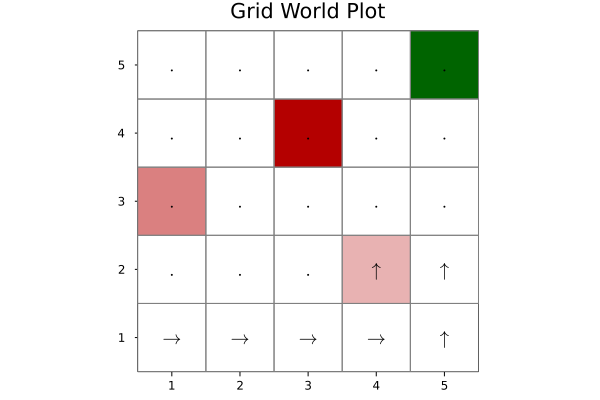

## Plotting Function

In [149]:
function plot_grid_world(mdp::POMDP,
        policy::Policy=NothingPolicy(),
        iter=0,
        discount=NaN;
        outline=true,
        show_policy=true,
        extra_title=isnan(discount) ? "" : " (iter=$iter, γ=$discount)",
        show_rewards=false,
        outline_state::Union{GridWorldState, Nothing}=nothing,
    pomdp=false,
    statess=Vector{GridWorldState},
    actionss=Vector{Symbol})
    
    #gr()

    if policy isa NothingPolicy
        # override when the policy is empty
        show_policy = false
    end
    
    if pomdp
        show_policy = true
    end
    
    if iter == 0
        # solver has not been run yet, so we just plot the raw rewards
        # overwrite policy at time=0 to be emp
        U = get_rewards(mdp, policy)
    else
        # otherwise, use the Value Function to get the values (i.e., utility)
        U = values(mdp, policy)
    end

    # reshape to grid
    
    xmax = mdp.size_x
    ymax = mdp.size_y
        
    Uxy = reshape(U[1:xmax*ymax], xmax, ymax) # need first 100 states because of boolean flags

    # plot values (i.e the U matrix)
    fig = heatmap(Uxy',
                  legend=:none,
                  aspect_ratio=:equal,
                  framestyle=:box,
                  tickdirection=:out,
                  color=cmap.colors)
    xlims!(0.5, xmax+0.5)
    ylims!(0.5, ymax+0.5)
    xticks!(1:xmax)
    yticks!(1:ymax)

    rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])
    
    if show_rewards
        for s in filter(s->reward(mdp, s, :up, GridWorldState(-1,-1)) != 0, states(mdp))
            r = reward(mdp, s, :up, GridWorldState(-1,-1))
            annotate!([(s.x, s.y, (r, :white, :center, 12, "Computer Modern"))])
        end
    end
    
    for x in 1:xmax, y in 1:ymax
        # display policy on the plot as arrows
        if show_policy
            if !pomdp
                grid = policy_grid(policy, xmax, ymax)
            else
                grid = action_grid(statess, actionss, xmax, ymax)
            end
#             @show grid
            annotate!([(x, y, (grid[x,y], :center, 12, "Computer Modern"))])
        end
        if outline
            rect = rectangle(1, 1, x - 0.5, y - 0.5)
            plot!(rect, fillalpha=0, linecolor=:gray)
        end
    end

    if !isnothing(outline_state)
        terminal_states = filter(s->reward(mdp, s) != 0, states(mdp))
        color = (outline_state in terminal_states) ? "yellow" : "blue"
        rect = rectangle(1, 1, outline_state.x - 0.5, outline_state.y - 0.5)
        plot!(rect, fillalpha=0, linecolor=color)
    end

    title!("Example Simulation Using FIB Policy$extra_title")

    return fig
end

plot_grid_world (generic function with 4 methods)

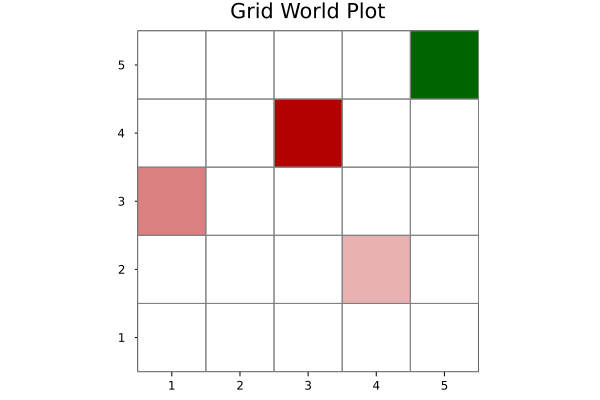

In [116]:
plot_grid_world(mdp)

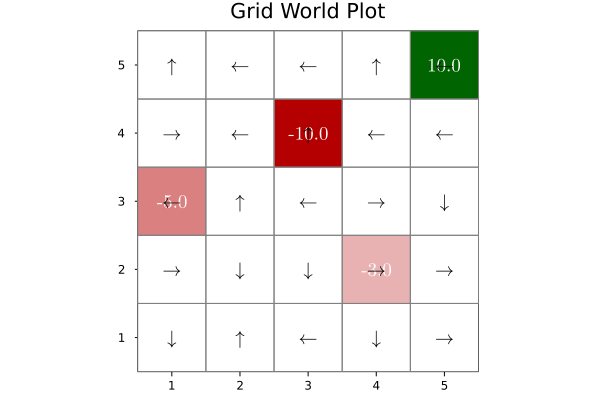

In [15]:
plot_grid_world(mdp, RandomPolicy(mdp), show_rewards=true)

## Distributions

## Transition Model

In [16]:
# transition helpers
function inbounds(mdp::GridWorld,x::Int64,y::Int64)
    if 1 <= x <= mdp.size_x && 1 <= y <= mdp.size_y
        return true
    else
        return false
    end
end

inbounds(mdp::GridWorld, state::GridWorldState) = inbounds(mdp, state.x, state.y);

In [17]:
function POMDPs.transition(mdp::GridWorld, state::GridWorldState, action::Symbol)
    a = action
    x = state.x
    y = state.y
    
    if state.done
        return SparseCat([GridWorldState(x, y, true)], [1.0])
    elseif state in mdp.reward_states
        return SparseCat([GridWorldState(x, y, true)], [1.0])
    end

    neighbors = [
        GridWorldState(x+1, y, false), # right
        GridWorldState(x-1, y, false), # left
        GridWorldState(x, y-1, false), # down
        GridWorldState(x, y+1, false), # up
        ] # See Performance Note below
    
    targets = Dict(:right=>1, :left=>2, :down=>3, :up=>4) # See Performance Note below
    target = targets[a]
    
    probability = fill(0.0, 4)

    if !inbounds(mdp, neighbors[target])
        # If would transition out of bounds, stay in
        # same cell with probability 1
        return SparseCat([GridWorldState(x, y)], [1.0])
    else
        probability[target] = mdp.tprob

        oob_count = sum(!inbounds(mdp, n) for n in neighbors) # number of out of bounds neighbors

        new_probability = (1.0 - mdp.tprob)/(3-oob_count)

        for i = 1:4 # do not include neighbor 5
            if inbounds(mdp, neighbors[i]) && i != target
                probability[i] = new_probability
            end
        end
    end
    
    idx = findall(x->x==0.0, probability)
    deleteat!(neighbors, idx)
    deleteat!(probability, idx)
#     @show idx
    
    return SparseCat(neighbors, probability)
end;

## Observation Model
Overrides the functions in POMDPs.jl

In [18]:
function POMDPs.observation(mdp::GridWorld, state::GridWorldState)
    x = state.x
    y = state.y
        
    if state.done
        return SparseCat([GridWorldState(x, y, true)], [1.0])
    elseif state in mdp.reward_states
        return SparseCat([GridWorldState(x, y, true)], [1.0])
    end

    neighbors = [
        GridWorldState(x, y, false),    # current state
        GridWorldState(x+1, y, false), # right
        GridWorldState(x-1, y, false), # left
        GridWorldState(x, y-1, false), # down
        GridWorldState(x, y+1, false), # up
        ] # See Performance Note below
        
    probability = fill(0.0, 5)

    if !inbounds(mdp, state)
        # If current state is out of bounds, return an error
        return "ERROR - current state out of bounds"
    else
        oob_count = sum(!inbounds(mdp, n) for n in neighbors) # number of out of bounds neighbors

        neighbor_probability = (1.0 - mdp.oprob)/(4-oob_count)
        
        probability[1] = mdp.oprob
        for i = 2:5 # do not include neighbor 5
            if inbounds(mdp, neighbors[i])
                probability[i] = neighbor_probability
            end
        end
    end
    
    idx = findall(x->x==0.0, probability)
    deleteat!(neighbors, idx)
    deleteat!(probability, idx)
#     @show idx

    return SparseCat(neighbors, probability)
end;

In [19]:
function POMDPs.observation(mdp::GridWorld, a::Symbol, state::GridWorldState)
    x = state.x
    y = state.y
        
    if state.done
        return SparseCat([GridWorldState(x, y, true)], [1.0])
    elseif state in mdp.reward_states
        return SparseCat([GridWorldState(x, y, true)], [1.0])
    end

    neighbors = [
        GridWorldState(x, y, false),    # current state
        GridWorldState(x+1, y, false), # right
        GridWorldState(x-1, y, false), # left
        GridWorldState(x, y-1, false), # down
        GridWorldState(x, y+1, false), # up
        ] # See Performance Note below
        
    probability = fill(0.0, 5)

    if !inbounds(mdp, state)
        # If current state is out of bounds, return an error
        return "ERROR - current state out of bounds"
    else
        oob_count = sum(!inbounds(mdp, n) for n in neighbors) # number of out of bounds neighbors

        neighbor_probability = (1.0 - mdp.oprob)/(4-oob_count)
        
        probability[1] = mdp.oprob
        for i = 2:5 # do not include neighbor 5
            if inbounds(mdp, neighbors[i])
                probability[i] = neighbor_probability
            end
        end
    end
    
    idx = findall(x->x==0.0, probability)
    deleteat!(neighbors, idx)
    deleteat!(probability, idx)
#     @show idx

    return SparseCat(neighbors, probability)
end;

In [20]:
function POMDPs.observation(mdp::GridWorld, state::GridWorldState, a::Symbol, sp::GridWorldState)
    x = sp.x
    y = sp.y
        
    if sp.done
        return SparseCat([GridWorldState(x, y, true)], [1.0])
    elseif sp in mdp.reward_states
        return SparseCat([GridWorldState(x, y, true)], [1.0])
    end

    neighbors = [
        GridWorldState(x, y, false),    # next state
        GridWorldState(x+1, y, false), # right
        GridWorldState(x-1, y, false), # left
        GridWorldState(x, y-1, false), # down
        GridWorldState(x, y+1, false), # up
        ] # See Performance Note below
        
    probability = fill(0.0, 5)

    if !inbounds(mdp, state)
        # If next state is out of bounds, return an error
        return "ERROR - current state out of bounds"
    else
        oob_count = sum(!inbounds(mdp, n) for n in neighbors) # number of out of bounds neighbors

        neighbor_probability = (1.0 - mdp.oprob)/(4-oob_count)
        
        probability[1] = mdp.oprob
        for i = 2:5 # do not include neighbor 5
            if inbounds(mdp, neighbors[i])
                probability[i] = neighbor_probability
            end
        end
    end
    
    idx = findall(x->x==0.0, probability)
    deleteat!(neighbors, idx)
    deleteat!(probability, idx)
#     @show idx

    return SparseCat(neighbors, probability)
end;

## Miscallenous Functions


In [21]:
POMDPs.discount(pomdp::GridWorld) = pomdp.discount_factor;

In [22]:
function POMDPs.stateindex(mdp::GridWorld, state::GridWorldState)
    sd = Int(state.done + 1)
    ci = CartesianIndices((mdp.size_x, mdp.size_y, 2))
    return LinearIndices(ci)[state.x, state.y, sd]
end

function POMDPs.actionindex(mdp::GridWorld, act::Symbol)
    if act==:up
        return 1
    elseif act==:down
        return 2
    elseif act==:left
        return 3
    elseif act==:right
        return 4
    end
    error("Invalid GridWorld action: $act")
end;

function POMDPs.obsindex(pomdp::GridWorld, obs::GridWorldState)
    sd = Int(obs.done + 1)
    ci = CartesianIndices((pomdp.size_x, pomdp.size_y, 2))
    return LinearIndices(ci)[obs.x, obs.y, sd]
end

In [23]:
using BeliefUpdaters

POMDPs.updater(mdp::GridWorld) = DiscreteUpdater(mdp)
POMDPs.Updater(mdp::GridWorld) = DiscreteUpdater(mdp)

In [24]:
POMDPs.isterminal(mdp::GridWorld, s::GridWorldState) = s.done

In [25]:
POMDPs.initialstate(pomdp::GridWorld) = Deterministic(GridWorldState(1,1))

In [26]:
# POMDPs.initialobs(pomdp::GridWorld, s) = POMDPs.initialstate(mdp)

# Simulations
Stepping through an example trajectory

In [27]:
POMDPs.initialstate(pomdp::GridWorld) = Deterministic(GridWorldState(1,1))
mdp = GridWorld()

left_policy  = FunctionPolicy(s->:left)
right_policy = FunctionPolicy(s->:right)

for (s,a,r,o,sp, b) in stepthrough(mdp, right_policy, "s,a,r,o,sp,b", max_steps=10)
    @show s.x, s.y
    @show a
    @show r
    @show o.x, o.y
    @show sp.x, sp.y
    @show b
#     @show POMDPs.transition(mdp, s, a)
#     @show POMDPs.observation(mdp, s, a, )
#     print(typeof(POMDPs.observation(mdp, s)))
    println()
end

(s.x, s.y) = (1, 1)
a = :right
r = 0.0
(o.x, o.y) = (2, 2)
(sp.x, sp.y) = (1, 2)
b = Deterministic{GridWorldState}(GridWorldState(1, 1, false))

(s.x, s.y) = (1, 2)
a = :right
r = 0.0
(o.x, o.y) = (2, 2)
(sp.x, sp.y) = (2, 2)
b = GridWorldState(2, 2, false)

(s.x, s.y) = (2, 2)
a = :right
r = 0.0
(o.x, o.y) = (4, 2)
(sp.x, sp.y) = (3, 2)
b = GridWorldState(2, 2, false)

(s.x, s.y) = (3, 2)
a = :right
r = 0.0
(o.x, o.y) = (4, 2)
(sp.x, sp.y) = (4, 2)
b = GridWorldState(4, 2, false)

(s.x, s.y) = (4, 2)
a = :right
r = -3.0
(o.x, o.y) = (4, 2)
(sp.x, sp.y) = (4, 2)
b = GridWorldState(4, 2, true)



## Solving the POMDP

In [28]:
# first let's load the value iteration module
using QMDP
using PointBasedValueIteration
using FIB
using POMDPLinter
using SARSOP

# initialize the problem
mdp = GridWorld()
# mdp.oprob=1.0

# initialize the solver
# solver = QMDPSolver(max_iterations=100; verbose=true)
# solver = PBVISolver(max_iterations=10; verbose=true)
# solver = FIBSolver()
solver = SARSOPSolver(verbose=true)

# solve for an optimal policy
pi = solve(solver, mdp); 
pi



Generating a pomdpx file: model.pomdpx

Loading the model ...
  input file   : model.pomdpx
  loading time : 0.00s 

SARSOP initializing ...
  initialization time : 0.02s

-------------------------------------------------------------------------------
 Time   |#Trial |#Backup |LBound    |UBound    |Precision  |#Alphas |#Beliefs  
-------------------------------------------------------------------------------
 0.02    0       0        -8.20831e-05 0.56826    0.568343    4        1        
 0.02    2       50       0.284903   0.594036   0.309133    46       17       
 0.03    6       100      0.474075   0.593259   0.119184    96       25       
 0.04    9       150      0.501373   0.586673   0.0853004   134      39       
 0.05    11      200      0.523402   0.584399   0.0609968   176      53       
 0.06    14      250      0.536273   0.580795   0.0445221   191      64       
 0.07    18      301      0.549185   0.578906   0.0297203   221      74       
 0.08    20      353      0.55401

AlphaVectorPolicy{GridWorld, Symbol}(GridWorld(5, 5, GridWorldState[GridWorldState(5, 5, false), GridWorldState(3, 4, false), GridWorldState(1, 3, false), GridWorldState(4, 2, false)], [10.0, -10.0, -5.0, -3.0], 0.7, 0.8, 0.9), 50, [[-8.20831e-5, -0.0930243, -0.27537, -0.729394, -1.11781, -8.20831e-5, -0.413257, -0.87622, -3.0, -2.4381  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [-2.67605, -1.23815, -0.596146, -1.94061, 1.18927, -3.56872, -3.56686, -4.51858, -3.0, 2.84288  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [-0.19787, -0.718966, 0.485865, 0.501842, 1.50597, -0.82145, -0.431707, -2.51443, -3.0, -0.0476796  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [-1.04258, -0.581762, -0.0938874, -1.79085, 2.33162, -3.32399, -1.66826, -3.95784, -3.0, 2.90598  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [-1.92631, -0.777876, 0.427255, -1.78449, 2.33462, -3.37003, -3.43604, -4.41977, -3.0, 2.97285  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [

In [29]:
for alpha in pi.action_map
    @show alpha
end

@assert length(pi.action_map) == length(pi.alphas)

alpha = :left
alpha = :up
alpha = :right
alpha = :up
alpha = :up
alpha = :up
alpha = :up
alpha = :down
alpha = :right
alpha = :right
alpha = :down
alpha = :right
alpha = :up
alpha = :right
alpha = :up
alpha = :down
alpha = :right
alpha = :up
alpha = :right
alpha = :down
alpha = :up
alpha = :up
alpha = :right
alpha = :down
alpha = :up
alpha = :right
alpha = :up
alpha = :up
alpha = :up
alpha = :right
alpha = :down
alpha = :up
alpha = :down
alpha = :up
alpha = :right
alpha = :down
alpha = :down
alpha = :down
alpha = :right
alpha = :up
alpha = :up
alpha = :down
alpha = :up
alpha = :right
alpha = :right
alpha = :right
alpha = :up
alpha = :down
alpha = :right
alpha = :right
alpha = :right
alpha = :right
alpha = :right
alpha = :right
alpha = :right
alpha = :down
alpha = :right
alpha = :up
alpha = :up
alpha = :up
alpha = :up
alpha = :up
alpha = :up
alpha = :right
alpha = :up
alpha = :right
alpha = :right
alpha = :up
alpha = :right
alpha = :up
alpha = :right
alpha = :up
alpha = :right
alpha = :

alpha = :right
alpha = :right
alpha = :right
alpha = :up
alpha = :right
alpha = :right
alpha = :up
alpha = :right
alpha = :right
alpha = :up
alpha = :right
alpha = :up
alpha = :right
alpha = :right
alpha = :up
alpha = :right
alpha = :right
alpha = :up
alpha = :right
alpha = :right
alpha = :right
alpha = :down
alpha = :right
alpha = :down
alpha = :right
alpha = :up
alpha = :right
alpha = :up
alpha = :up
alpha = :up
alpha = :right
alpha = :up
alpha = :right
alpha = :down
alpha = :right
alpha = :down
alpha = :right
alpha = :right
alpha = :right
alpha = :up
alpha = :up
alpha = :up
alpha = :right
alpha = :right
alpha = :right
alpha = :up
alpha = :right
alpha = :up
alpha = :up
alpha = :right
alpha = :up
alpha = :up
alpha = :up
alpha = :up
alpha = :up
alpha = :right
alpha = :up
alpha = :up
alpha = :right
alpha = :up
alpha = :right
alpha = :right
alpha = :up
alpha = :right
alpha = :up
alpha = :right
alpha = :up
alpha = :up
alpha = :right
alpha = :up
alpha = :right
alpha = :up
alpha = :right
al

alpha = :right
alpha = :right
alpha = :right
alpha = :right
alpha = :right
alpha = :up
alpha = :right
alpha = :up
alpha = :down
alpha = :up
alpha = :down
alpha = :up
alpha = :down
alpha = :up
alpha = :down
alpha = :up
alpha = :down
alpha = :up
alpha = :down
alpha = :up
alpha = :down
alpha = :right
alpha = :down
alpha = :up
alpha = :down
alpha = :up
alpha = :down
alpha = :up
alpha = :down
alpha = :up
alpha = :down
alpha = :up
alpha = :down
alpha = :up
alpha = :down
alpha = :up
alpha = :right
alpha = :up
alpha = :right
alpha = :right
alpha = :right
alpha = :right
alpha = :right
alpha = :down
alpha = :right
alpha = :right
alpha = :right
alpha = :right
alpha = :right
alpha = :right
alpha = :right
alpha = :down
alpha = :right
alpha = :right
alpha = :right
alpha = :right
alpha = :up
alpha = :right
alpha = :right
alpha = :right
alpha = :up
alpha = :down
alpha = :up
alpha = :down
alpha = :up
alpha = :down
alpha = :up
alpha = :down
alpha = :up
alpha = :up
alpha = :right
alpha = :up
alpha = :up


## Functions for Utility and Choosing Actions

In [30]:
function utility(π::AlphaVectorPolicy, b)
    return maximum([dot(α, b) for α in π.alphas])
end

function greedyaction(π::AlphaVectorPolicy, b)
    i =  argmax([dot(α, b) for α in π.alphas])
    return π.action_map[i]
end


greedyaction (generic function with 1 method)

In [31]:
# b = beliefvec(mdp, uniform_belief(mdp))
b = beliefvec(mdp, Deterministic(GridWorldState(1,1)))

@show b
@show utility(pi, b)
@show greedyaction(pi, b)

b = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
utility(pi, b) = 0.564063
greedyaction(pi, b) = :right


:right

## Simulation using SARSOP Simulator

In [32]:
using POMDPModelTools
using LinearAlgebra

# simulate the SARSOP policy

# for i in 1:100
#     simulator = SARSOPSimulator(sim_num = 1, sim_len = 10, 
#                             policy_filename = "policy.out",
#                             pomdp_filename = "model.pomdpx",
#                             srand=i)
#     results = SARSOP.simulate(simulator) 
# end

simulator = SARSOPSimulator(sim_num = 1000, sim_len = 10, 
                            policy_filename = "policy.out",
                            pomdp_filename = "model.pomdpx")
results = SARSOP.simulate(simulator) 

# discounted_reward(results)

# @show results

# # evaluate the SARSOP policy
# evaluator = SARSOPEvaluator(sim_num = 10, sim_len = 10, 
#                             policy_filename = "policy.out",
#                             pomdp_filename = "model.pomdpx")


# SARSOP.evaluate(evaluator)

# generates a policy graph
# graphgen = PolicyGraphGenerator(graph_filename = "Graph.dot",
#                                 policy_filename = "policy.out",
#                                 pomdp_filename = "model.pomdpx")

# generate_graph(graphgen)



Loading the model ...
  input file   : model.pomdpx

Loading the policy ...
  input file   : policy.out

Simulating ...
  action selection :  one-step look ahead

-----------------------------------
 #Simulations  | Exp Total Reward  
-----------------------------------
 100             -0.235863
 200             -0.194909
 300             -0.250199
 400             -0.329239
 500             -0.320153
 600             -0.285351
 700             -0.230898
 800             -0.264085
 900             -0.212841
 1000            -0.232835
-----------------------------------

Finishing ...

-------------------------------------------------------------
 #Simulations  | Exp Total Reward | 95% Confidence Interval 
-------------------------------------------------------------
 1000            -0.232835          (-0.337271, -0.128398)
-------------------------------------------------------------


Process(`/home/bdobkowski/.julia/artifacts/9dc495ed777b7a92379fc79a8ef3ba6a4ff0d511/bin/pomdpsim model.pomdpx --policy-file policy.out --simLen 10 --simNum 1000 --output-file ''`, ProcessExited(0))

In [33]:
# using POMDPLinter
# using DiscreteValueIteration
# POMDPLinter.@show_requirements(solve(QMDPSolver(), GridWorld()))
# @show statetype(mdp)
# POMDPLinter.@show_requirements(solve(PBVISolver(), mdp))
# POMDPLinter.@show_requirements(solve(FIBSolver(), mdp))
# POMDPLinter.@show_requirements(solve(ValueIterationSolver(), mdp))
# POMDPLinter.@show_requirements(solve(SARSOPSolver(), mdp))


In [146]:
pomdp = GridWorld()
pomdp.oprob = 1.0
pomdp.tprob = 0.8
@show pomdp

n_simulations = 15000

# solver = SARSOPSolver(verbose=true)
# @show solver
# pi = solve(solver, pomdp)

# solver = QMDPSolver(verbose=true)
# @show solver
# pi = solve(solver, pomdp)

solver = FIBSolver(verbose=true)
@show solver
pi = solve(solver, pomdp)

vec = zeros(length(states(pomdp)))
vec[1] = 1.0

r_total = zeros(n_simulations)

for sim in 1:n_simulations
    statess = Vector{GridWorldState}()
    actionss = Vector{Symbol}()
    b = DiscreteBelief(pomdp, vec)
    s = GridWorldState(1, 1, false)
    r = 0
    for iter in 1:15
        a = greedyaction(pi, beliefvec(pomdp, b))
        push!(statess, s)
        push!(actionss, a)
        s = rand(transition(pomdp, s, a))
        r += pomdp.discount_factor^(iter) * reward(pomdp, s, a)
        o = observation(pomdp, s)
        b = update(updater(pomdp), b, a, rand(o))
        if s.done
            break
        end
    end
    r_total[sim] = r
end

mean(r_total)

pomdp = GridWorld(5, 5, GridWorldState[GridWorldState(5, 5, false), GridWorldState(3, 4, false), GridWorldState(1, 3, false), GridWorldState(4, 2, false)], [10.0, -10.0, -5.0, -3.0], 0.8, 1.0, 0.9)
solver = FIBSolver(100, 0.001, true)
[Iteration 1   ] residual:         10 
[Iteration 2   ] residual:        7.2 
[Iteration 3   ] residual:       6.48 
[Iteration 4   ] residual:       4.65 
[Iteration 5   ] residual:       3.31 
[Iteration 6   ] residual:       2.24 
[Iteration 7   ] residual:        1.4 
[Iteration 8   ] residual:       1.09 
[Iteration 9   ] residual:       0.87 
[Iteration 10  ] residual:      0.758 
[Iteration 11  ] residual:       0.67 
[Iteration 12  ] residual:      0.585 
[Iteration 13  ] residual:      0.327 
[Iteration 14  ] residual:      0.287 
[Iteration 15  ] residual:      0.133 
[Iteration 16  ] residual:      0.116 
[Iteration 17  ] residual:      0.049 
[Iteration 18  ] residual:     0.0429 
[Iteration 19  ] residual:     0.0172 
[Iteration 20  ] residua

1.85073470944901

In [147]:
statess
actionss

9-element Vector{Symbol}:
 :right
 :right
 :right
 :up
 :right
 :right
 :right
 :up
 :up

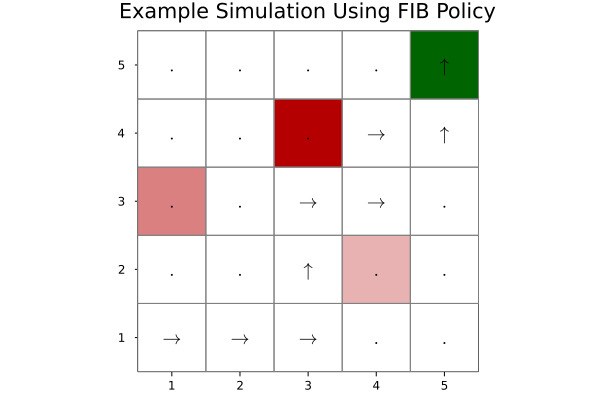

In [150]:
plot_grid_world(pomdp, pomdp=true, statess=statess, actionss=actionss)

# Trying Different Observation Probabilities

In [35]:
solver = SARSOPSolver(verbose=true)

for obs_prob in 0.5:0.1:1.0
    print("Observation Probability: ", obs_prob, "\n\n")
    pomdp = GridWorld()
    pomdp.oprob = obs_prob
    pomdp.tprob = 1.0
    @show pomdp.oprob
    pi = solve(solver, pomdp); 
    sleep(2)
    simulator = SARSOPSimulator(sim_num = 10, sim_len = 10, 
                            policy_filename = "policy.out",
                            pomdp_filename = "model.pomdpx")
    results = SARSOP.simulate(simulator) 
end

# pomdp = GridWorld()
# pomdp.oprob = 0.2
# pomdp.tprob = 1.0
# @show pomdp
# solver = SARSOPSolver(verbose=true)
# pi = solve(solver, pomdp); 
# # sleep(2)
# # simulator = SARSOPSimulator(sim_num = 10, sim_len = 10, 
# #                         policy_filename = "policy.out",
# #                         pomdp_filename = "model.pomdpx")
# # results = SARSOP.simulate(simulator) 

# history = HistoryRecorder(max_steps=1000)

# hist = simulate(history, pomdp, pi, DiscreteUpdater(pomdp), b0=initialstate(pomdp), s0=GridWorldState(1,1,false))


@show 0.9^8*10

Observation Probability: 0.5

pomdp.oprob = 0.5
Generating a pomdpx file: model.pomdpx

Loading the model ...
  input file   : model.pomdpx
  loading time : 0.00s 

SARSOP initializing ...
  initialization time : 0.00s

-------------------------------------------------------------------------------
 Time   |#Trial |#Backup |LBound    |UBound    |Precision  |#Alphas |#Beliefs  
-------------------------------------------------------------------------------
 0       0       0        -8.20831e-05 4.30467    4.30475     4        1        
 0       1       11       4.30467    4.30467    0           13       6        
-------------------------------------------------------------------------------

SARSOP finishing ...
  target precision reached
  target precision  : 0.001000
  precision reached : 0.000000 

-------------------------------------------------------------------------------
 Time   |#Trial |#Backup |LBound    |UBound    |Precision  |#Alphas |#Beliefs  
---------------------------


Loading the model ...
  input file   : model.pomdpx

Loading the policy ...
  input file   : policy.out

Simulating ...
  action selection :  one-step look ahead

-----------------------------------
 #Simulations  | Exp Total Reward  
-----------------------------------
 1               4.30467
 2               4.30467
 3               4.30467
 4               4.30467
 5               4.30467
 6               4.30467
 7               4.30467
 8               4.30467
 9               4.30467
 10              4.30467
-----------------------------------

Finishing ...

-------------------------------------------------------------
 #Simulations  | Exp Total Reward | 95% Confidence Interval 
-------------------------------------------------------------
 10              4.30467            (4.30467, 4.30467)
-------------------------------------------------------------
Observation Probability: 1.0

pomdp.oprob = 1.0
Generating a pomdpx file: model.pomdpx

Loading the model ...
  input file  

4.304672100000001